## **This Notebook is adapted from: https://fneum.github.io/data-science-for-esm/intro.html and https://open-energy-transition.github.io/data-science-for-esm/09-workshop-pypsa.html**

# Introduction to `pypsa`

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Stanford-Sustainable-Systems-Lab/CEE_272R_spring_2024/blob/main/Discussion_Sections/Discussion-PyPSA_Intro/CEE272R_Spring_2024_Disc7_PyPSA_Introduction.ipynb)

<img src="https://github.com/fneum/data-science-for-esm/raw/main/data-science-for-esm/pypsa-logo.png" width="300px" />

PyPSA stands for **Python for Power System Analysis**.

PyPSA is an open source Python package for simulating and optimising modern energy systems that include features such as

- conventional generators with unit commitment (ramp-up, ramp-down, start-up, shut-down),
- time-varying wind and solar generation,
- energy storage with efficiency losses and inflow/spillage for hydroelectricity
- coupling to other energy sectors (electricity, transport, heat, industry),
- conversion between energy carriers (e.g. electricity to hydrogen),
- transmission networks (AC, DC, other fuels)

PyPSA can be used for a variety of problem types (e.g. electricity market modelling, long-term investment planning, transmission network expansion planning), and is designed to scale well with large networks and long time series.

Compared to building power system by hand in `pyomo`, PyPSA does the following things for you:

- manage data inputs
- build optimisation problem
- communicate with the solver
- retrieve and process optimisation results
- manage data outputs

### Dependencies

- `pandas` for storing data about network components and time series
- `numpy` and `scipy` for linear algebra and sparse matrix calculations
- `matplotlib` and `cartopy` for plotting on a map
- `networkx` for network calculations
- `linopy` for handling optimisation problems

:::{note}
Documentation for this package is available at https://pypsa.readthedocs.io.
:::

## Basic Structure

| Component | Description |
| --- | --- |
| [Network](https://pypsa.readthedocs.io/en/latest/components.html#network) | Container for all components. |
| [Bus](https://pypsa.readthedocs.io/en/latest/components.html#bus) | Node where components attach. |
| [Carrier](https://pypsa.readthedocs.io/en/latest/components.html#carrier) | Energy carrier or technology (e.g. electricity, hydrogen, gas, coal, oil, biomass, on-/offshore wind, solar). Can track properties such as specific carbon dioxide emissions or nice names and colors for plots. |
| [Load](https://pypsa.readthedocs.io/en/latest/components.html#load) | Energy consumer (e.g. electricity demand). |
| [Generator](https://pypsa.readthedocs.io/en/latest/components.html#generator) | Generator (e.g. power plant, wind turbine, PV panel). |
| [Line](https://pypsa.readthedocs.io/en/latest/components.html#line) | Power distribution and transmission lines (overhead and cables). |
| [Link](https://pypsa.readthedocs.io/en/latest/components.html#link) | Links connect two buses with controllable energy flow, direction-control and losses. They can be used to model: <ul><li>HVDC links</li><li>HVAC lines (neglecting KVL, only net transfer capacities (NTCs))</li><li>conversion between carriers (e.g. electricity to hydrogen in electrolysis)</li><li>coupling between different sectors</li></ul> |
| [StorageUnit](https://pypsa.readthedocs.io/en/latest/components.html#storage-unit) | Storage with fixed nominal energy-to-power ratio. |
| [GlobalConstraint](https://pypsa.readthedocs.io/en/latest/components.html#global-constraints) | Constraints affecting many components at once, such as emission limits. |
| [Store](https://pypsa.readthedocs.io/en/latest/components.html#store) | Storage with separately extendable energy capacity. |
|  | **not used in this course** |
| [LineType](https://pypsa.readthedocs.io/en/latest/components.html#line-types) | Standard line types. |
| [Transformer](https://pypsa.readthedocs.io/en/latest/components.html#transformer) | 2-winding transformer. |
| [TransformerType](https://pypsa.readthedocs.io/en/latest/components.html#transformer-types) | Standard types of 2-winding transformer. |
| [ShuntImpedance](https://pypsa.readthedocs.io/en/latest/components.html#shunt-impedance) | Shunt. |


:::{note}
Links in the table lead to documentation for each component.
:::

<img src="https://pypsa.readthedocs.io/en/latest/_images/buses.png" width="500px" />


:::{warning}
Per unit values of voltage and impedance are used internally for network calculations. It is assumed internally that the base power is **1 MW**.
:::

## From structured data to optimisation

The design principle of PyPSA is that basically each component is associated with a set of variables and constraints that will be added to the optimisation model based on the input data stored for the components.

For an *hourly* electricity market simulation, PyPSA will solve an optimisation problem that looks like this

\begin{equation}
\min_{g_{i,s,t}; f_{\ell,t}; g_{i,r,t,\text{charge}}; g_{i,r,t,\text{discharge}}; e_{i,r,t}} \sum_s o_{s} g_{i,s,t}
\end{equation}
such that
\begin{align}
0 & \leq g_{i,s,t} \leq \hat{g}_{i,s,t} G_{i,s}  & \text{generation limits : generator} \\
-F_\ell &\leq f_{\ell,t} \leq F_\ell & \text{transmission limits : line}  \\
d_{i,t} &= \sum_s g_{i,s,t} + \sum_r g_{i,r,t,\text{discharge}} - \sum_r g_{i,r,t,\text{charge}} - \sum_\ell K_{i\ell} f_{\ell,t} & \text{KCL : bus} \\
 0 &=\sum_\ell C_{\ell c} x_\ell f_{\ell,t} & \text{KVL : cycles} \\
0 & \leq g_{i,r,t,\text{discharge}} \leq G_{i,r,\text{discharge}}& \text{discharge limits : storage unit} \\
    0 & \leq g_{i,r,t,\text{charge}} \leq G_{i,r,\text{charge}} & \text{charge limits : storage unit} \\
    0 & \leq e_{i,r,t} \leq E_{i,r} & \text{energy limits : storage unit} \\
    e_{i,r,t} &= \eta^0_{i,r,t} e_{i,r,t-1} + \eta^1_{i,r,t}g_{i,r,t,\text{charge}} -  \frac{1}{\eta^2_{i,r,t}} g_{i,r,t,\text{discharge}} & \text{consistency : storage unit} \\
    e_{i,r,0} & = e_{i,r,|T|-1}  & \text{cyclicity : storage unit}
\end{align}

**Decision variables:**

- $g_{i,s,t}$ is the generator dispatch at bus $i$, technology $s$, time step $t$,
- $f_{\ell,t}$ is the power flow in line $\ell$,
- $g_{i,r,t,\text{dis-/charge}}$ denotes the charge and discharge of storage unit $r$ at bus $i$ and time step $t$,
- $e_{i,r,t}$ is the state of charge of storage $r$ at bus $i$ and time step $t$.

**Parameters:**

- $o_{i,s}$ is the marginal generation cost of technology $s$ at bus $i$,
- $x_\ell$ is the reactance of transmission line $\ell$,
- $K_{i\ell}$ is the incidence matrix,
- $C_{\ell c}$ is the cycle matrix,
- $G_{i,s}$ is the nominal capacity of the generator of technology $s$ at bus $i$,
- $F_{\ell}$ is the rating of the transmission line $\ell$,
- $E_{i,r}$ is the energy capacity of storage $r$ at bus $i$,
- $\eta^{0/1/2}_{i,r,t}$ denote the standing (0), charging (1), and discharging (2) efficiencies.

:::{note}
For a full reference to the optimisation problem description, see https://pypsa.readthedocs.io/en/latest/optimal_power_flow.html
:::

#Install Dependencies

In [ ]:
!pip install pypsa matplotlib cartopy highspy xarray==2023.9.0
!pip list

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.0/171.0 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.4/381.4 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5

In [ ]:
!pip install pypsa matplotlib cartopy highspy xarray==2023.9.0
import matplotlib.pyplot as plt

## Simple electricity market example

Let's get acquainted with PyPSA to build a variant of one of the simple electricity market models. In this example we will build an extremely simlple 2 node network with a single time slice. You'll get a sense of what data comprises a network model.

We have the following data:

- fuel costs in \$ / MWh$_{th}$

In [ ]:
fuel_cost = dict(
    gas=100,
    coal=5
)

- efficiencies of thermal power plants in MWh$_{el}$ / MWh$_{th}$

In [ ]:
efficiency = dict(
    gas=0.58,
    coal=0.45
)

- specific emissions in t$_{CO_2}$ / MWh$_{th}$

In [ ]:
# t/MWh thermal
emissions = dict(
    gas=0.2,
    coal=0.8
)

- power plant capacities in MW

In [ ]:
power_plants = {
    "CA": {"gas": 35000, "solar": 30000, "coal": 5000},
    "MX": {"wind": 60000},
}

- electrical load in MW

In [ ]:
loads = {
    "CA": 52000,
    "MX": 40000,
}

## Building a basic network

By convention, PyPSA is imported without an alias:

In [ ]:
import pypsa

First, we create a new network object which serves as the overall container for all components.

In [ ]:
n = pypsa.Network()

The second component we need are buses. **Buses** are the fundamental nodes of the network, to which all other components like loads, generators and transmission lines attach. They enforce energy conservation for all elements feeding in and out of it (i.e. Kirchhoff’s Current Law).

<img src="https://pypsa.readthedocs.io/en/latest/_images/buses.png" width="500px" />

Components can be added to the network `n` using the `n.add()` function. It takes the component name as a first argument, the name of the component as a second argument and possibly further parameters as keyword arguments. Let's use this function, to add buses for each country to our network:

In [ ]:
n.add("Bus", "CA", x=-122.17, y=37.42, v_nom=400, carrier="AC")
n.add("Bus", "MX", x=-99.10, y=19.38, v_nom=400, carrier="AC")

For each class of components, the data describing the components is stored in a `pandas.DataFrame`. For example, all static data for buses is stored in `n.buses`

In [ ]:
n.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
CA,400.0,,-122.17,37.42,AC,None,1.0,0.0,inf,PQ,
MX,400.0,,-99.10,19.38,AC,None,1.0,0.0,inf,PQ,


You see there are many more attributes than we specified while adding the buses; many of them are filled with default parameters which were added. You can look up the field description, defaults and status (required input, optional input, output) for buses here https://pypsa.readthedocs.io/en/latest/components.html#bus, and analogous for all other components.

There's a variant of `n.add()` called `n.madd()` which allows you to add multiple components at once. For instance, multiple **carriers** for the fuels with information on specific carbon dioxide emissions, a nice name, and colors for plotting.

The function `n.madd()` again takes the component name as the first argument and then a list of component names and then optional arguments for the parameters. Here, scalar values, lists, dictionary or `pandas.Series` are allowed. The latter two needs keys or indices with the component names.

In [ ]:
emissions

{'gas': 0.2, 'coal': 0.8}

In [ ]:
n.madd(
    "Carrier",
    ["coal", "gas", "solar", "wind"],
    co2_emissions=emissions,
    nice_name=["Coal", "Gas", "Solar PV", "Onshore Wind"],
    color=["black", "grey", "yellow", "dodgerblue"],
)

Index(['coal', 'gas', 'solar', 'wind'], dtype='object')

In [ ]:
n.carriers

,co2_emissions,nice_name,color,max_growth,max_relative_growth
Carrier,,,,,
coal,0.8,Coal,black,inf,0.0
gas,0.2,Gas,grey,inf,0.0
solar,NaN,Solar PV,yellow,inf,0.0
wind,NaN,Onshore Wind,dodgerblue,inf,0.0


The `n.add()` function is very general. It lets you add any component to the network object `n`. For instance, in the next step we add **generators** for all the different power plants.

In Mexico:

In [ ]:
n.add(
    "Generator",
    "MX wind",
    bus="MX",
    carrier="wind",
    p_nom=power_plants["MX"].get("wind"),  # MW
    marginal_cost=0,  # default
)

In California (in a loop):

In [ ]:
for tech, p_nom in power_plants["CA"].items():
    n.add(
        "Generator",
        f"CA {tech}",
        bus="CA",
        carrier=tech,
        efficiency=efficiency.get(tech, 1),
        p_nom=p_nom,
        marginal_cost=fuel_cost.get(tech, 0) / efficiency.get(tech, 1),
    )

As a result, the `n.generators` DataFrame looks like this:

In [ ]:
n.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
MX wind,MX,PQ,,60000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
CA gas,CA,PQ,,35000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
CA solar,CA,PQ,,30000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
CA coal,CA,PQ,,5000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


Next, we're going to add the electricity demand.

A positive value for `p_set` means consumption of power from the bus.

In [ ]:
n.add(
    "Load",
    "CA electricity demand",
    bus="CA",
    p_set=loads["CA"],
    carrier="electricity",
)

In [ ]:
n.add(
    "Load",
    "MX electricity demand",
    bus="MX",
    p_set=loads["MX"],
    carrier="electricity",
)

In [ ]:
n.loads

attribute,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
CA electricity demand,CA,electricity,,52000.0,0.0,-1.0
MX electricity demand,MX,electricity,,40000.0,0.0,-1.0


Finally, we add the connection between California and Mexico with a 20 GW line:

In [ ]:
n.add(
    "Line",
    "CA-MX",
    bus0="CA",
    bus1="MX",
    s_nom=20e3,
    x=1,
    r=1,
)

In [ ]:
n.lines

attribute,bus0,bus1,type,x,r,g,b,s_nom,s_nom_extendable,s_nom_min,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
CA-MX,CA,MX,,1.0,1.0,0.0,0.0,20000.0,False,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can have a sneak peek at the network we built with the `n.plot()` function. More details on this in a bit.

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



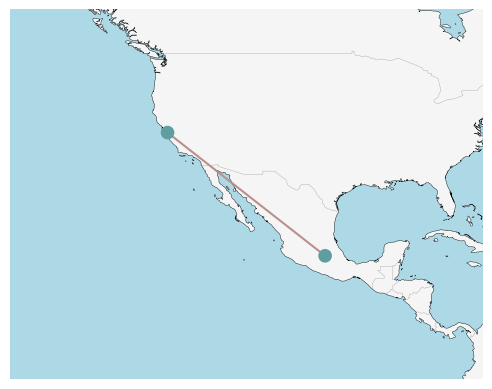

In [ ]:
n.plot(bus_sizes=1, margin=1, color_geomap=True);

## Optimisation

With all input data transferred into PyPSA's data structure, we can now build and run the resulting optimisation problem. In PyPSA, building, solving and retrieving results from the optimisation model is contained in a single function call `n.optimize()`. This function optimizes dispatch and investment decisions for least cost.

The `n.optimize()` function can take a variety of arguments. The most relevant for the moment is the choice of the solver. We already know the different solvers from the introduction to `pyomo` (e.g. "cbc", "glpk", "gurobi" etc.). They need to be installed on your computer, to use them here!

In [ ]:
n.optimize(solver_name="highs")

('ok', 'optimal')

Let's have a look at the results.

Since the power flow and dispatch are generally time-varying quantities, these are stored in a different location than e.g. `n.generators`. They are stored in `n.generators_t`. Thus, to find out the dispatch of the generators, run

In [ ]:
n.generators_t.p

Generator,MX wind,CA gas,CA solar,CA coal
snapshot,,,,
now,60000.0,-0.0,30000.0,2000.0


or if you prefer it in relation to the generators nominal capacity

In [ ]:
n.generators_t.p / n.generators.p_nom

Generator,MX wind,CA gas,CA solar,CA coal
snapshot,,,,
now,1.0,-0.0,1.0,0.4


You see that the time index has the value 'now'. This is the default index when no time series data has been specified and the network only covers a single state (e.g. a particular hour).

Similarly you will find the power flow in transmission lines at

In [ ]:
n.lines_t.p0

Line,CA-MX
snapshot,
now,-20000.0


In [ ]:
n.lines_t.p1

Line,CA-MX
snapshot,
now,20000.0


In [ ]:
n.lines

attribute,bus0,bus1,type,x,r,g,b,s_nom,s_nom_extendable,s_nom_min,...,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom
Line,,,,,,,,,,,,,,,,,,,,,
CA-MX,CA,MX,,1.0,1.0,0.0,0.0,20000.0,False,0.0,...,inf,0,0.000006,0.000006,0.0,0.0,0.000006,0.000006,20000.0,400.0


The `p0` will tell you the flow from `bus0` to `bus1`. `p1` will tell you the flow from `bus1` to `bus0`.

What about the shadow prices?

In [ ]:
n.buses_t.marginal_price

Bus,CA,MX
snapshot,,
now,11.111111,-0.0


The `statistics` module comes in handy for a quick overview.

In [ ]:
n.statistics()

Capacity Factor  Capital Expenditure  Curtailment  \
          carrier                                                           
Generator Coal                      0.4                  0.0          0.0   
          Gas                       0.0                  0.0          0.0   
          Onshore Wind              1.0                  0.0          0.0   
          Solar PV                  1.0                  0.0          0.0   
Line      AC                        1.0                  0.0          NaN   
Load      electricity               NaN                  NaN          NaN   

                        Dispatch  Installed Capacity  Market Value  \
          carrier                                                    
Generator Coal            2000.0              5000.0     11.111111   
          Gas                0.0             35000.0           NaN   
          Onshore Wind   60000.0             60000.0      0.000000   
          Solar PV       30000.0             30000.0     11.111111   
Line      AC             20000.0             20000.0     11.111111   
Load      electricity   -92000.0                 NaN     -6.280193   

                        Operational Expenditure  Optimal Capacity  \
          carrier                                                   
Generator Coal                     22222.222222            5000.0   
          Gas                          0.000000           35000.0   
          Onshore Wind                 0.000000           60000.0   
          Solar PV                     0.000000           30000.0   
Line      AC                                NaN           20000.0   
Load      electricity                       NaN               NaN   

                              Revenue   Supply  Withdrawal  
          carrier                                           
Generator Coal           22222.222222   2000.0         0.0  
          Gas                0.000000      0.0         0.0  
          Onshore Wind       0.000000  60000.0         0.0  
          Solar PV      333333.333333  30000.0         0.0  
Line      AC            222222.222222  20000.0    -20000.0  
Load      electricity   577777.777777      0.0    -92000.0

In [ ]:
n.add(
    "Bus",
    "EV Node",
    v_nom=400,
)
n.add(
    "Link",
    "EV Link",

)

# Plotting Networks Example

PyPSA has a built-in plotting function based on `matplotlib`, ....

(<matplotlib.collections.PatchCollection at 0x7c0794ab91b0>,
 <matplotlib.collections.LineCollection at 0x7c0794a8bfa0>)

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



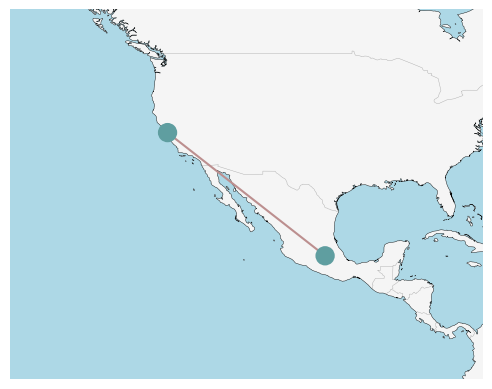

In [ ]:
n.plot(margin=1, bus_sizes=2, color_geomap=True)

We can use the `bus_sizes` argument of `n.plot()` to display the regional distribution of load. First, we calculate the total load per bus:

In [ ]:
s = n.loads.groupby("bus").p_set.sum() / 1e4

In [ ]:
s

bus
CA    5.2
MX    4.0
Name: p_set, dtype: float64

The resulting `pandas.Series` we can pass to `n.plot(bus_sizes=...)`:

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



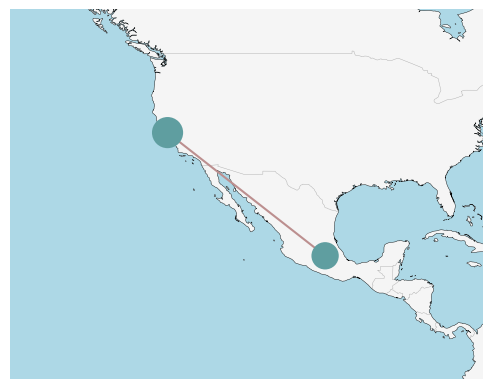

In [ ]:
n.plot(margin=1, bus_sizes=s, color_geomap=True);

The important point here is, that `s` needs to have entries for all buses, i.e. its index needs to match `n.buses.index`.

The `bus_sizes` argument of `n.plot()` can be even more powerful. It can produce pie charts, e.g. for the mix of electricity generation at each bus.

The dispatch of each generator, we can find at:

In [ ]:
n.generators_t.p.loc["now"]

Generator
MX wind     60000.0
CA gas         -0.0
CA solar    30000.0
CA coal      2000.0
Name: now, dtype: float64

If we group this by the **bus** and **carrier**...

In [ ]:
s = n.generators_t.p.loc["now"].groupby([n.generators.bus, n.generators.carrier]).sum()

... we get a multi-indexed `pandas.Series` ...

In [ ]:
s

bus  carrier
CA   coal        2000.0
     gas            0.0
     solar      30000.0
MX   wind       60000.0
Name: now, dtype: float64

... which we can pass to `n.plot(bus_sizes=...)`:

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



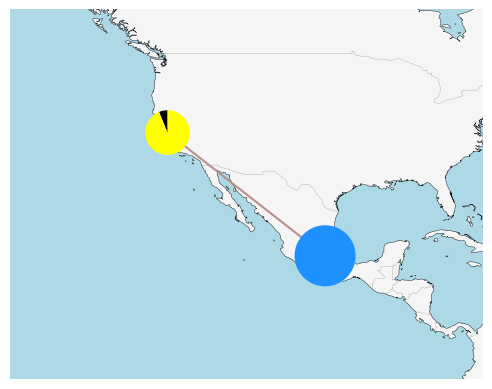

In [ ]:
n.plot(margin=1, bus_sizes=s / 3000, color_geomap=True);

**How does this magic work?** The plotting function will look up the colors specified in `n.carriers` for each carrier and match it with the second index-level of `s`.

## Modifying networks

Modifying data of components in an existing PyPSA network is as easy as modifying the entries of a `pandas.DataFrame`. For instance, if we want to reduce the solar power output by half, we'd run:

In [ ]:
n.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
MX wind,MX,Slack,,60000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,60000.0
CA gas,CA,PQ,,35000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,35000.0
CA solar,CA,PQ,,30000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,30000.0
CA coal,CA,PQ,,5000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,5000.0


In [ ]:
n.generators.loc["CA solar", "p_nom"] /= 2

In [ ]:
n.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
MX wind,MX,Slack,,60000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,60000.0
CA gas,CA,PQ,,35000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,35000.0
CA solar,CA,PQ,,15000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,30000.0
CA coal,CA,PQ,,5000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,5000.0


In [ ]:
n.lines

attribute,bus0,bus1,type,x,r,g,b,s_nom,s_nom_extendable,s_nom_min,...,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom
Line,,,,,,,,,,,,,,,,,,,,,
CA-MX,CA,MX,,1.0,1.0,0.0,0.0,20000.0,False,0.0,...,inf,0,0.000006,0.000006,0.0,0.0,0.000006,0.000006,20000.0,400.0


In [ ]:
n.optimize(solver_name="highs")

('ok', 'optimal')

You can see that the production of the coal power plant was increased and that of the gas power plant increased owing to the reduced solar capacity.

In [ ]:
n.generators_t.p

Generator,MX wind,CA gas,CA solar,CA coal
snapshot,,,,
now,60000.0,12000.0,15000.0,5000.0


/usr/local/lib/python3.10/dist-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



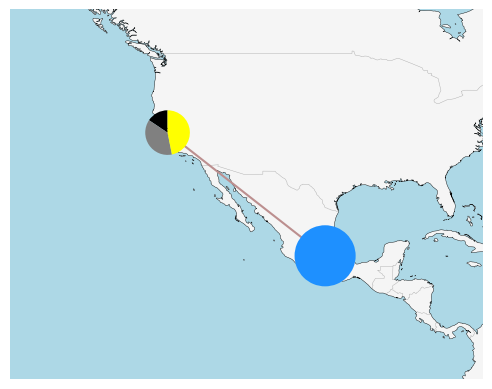

In [ ]:
s = n.generators_t.p.loc["now"].groupby([n.generators.bus, n.generators.carrier]).sum()
n.plot(margin=1, bus_sizes=s / 3000, color_geomap=True);

In [ ]:
n.carriers # to see what colors are

,co2_emissions,nice_name,color,max_growth,max_relative_growth
Carrier,,,,,
coal,0.8,Coal,black,inf,0.0
gas,0.2,Gas,grey,inf,0.0
solar,NaN,Solar PV,yellow,inf,0.0
wind,NaN,Onshore Wind,dodgerblue,inf,0.0


## Global constraints for emission limits

In the example above, we happen to have some spare gas capacity. We could use gas instead of coal to lower the emissions of the system, but it will be more expensive. We can implement the limit of carbon dioxide emissions as a constraint.

This is achieved in PyPSA through **Global Constraints** which add constraints that apply to many components at once.

But first, we need to calculate the current level of emissions to set a sensible limit.

We can compute the emissions per generator (in tonnes of CO$_2$) in the following way.

$$\frac{g_{i,s,t} \cdot \rho_{i,s}}{\eta_{i,s}}$$

where $ \rho$ is the specific emissions (tonnes/MWh thermal) and $\eta$ is the conversion efficiency (MWh electric / MWh thermal) of the generator with dispatch $g$ (MWh electric):

In [ ]:
e = (
    n.generators_t.p
    / n.generators.efficiency
    * n.generators.carrier.map(n.carriers.co2_emissions)
)
e

Generator,MX wind,CA gas,CA solar,CA coal
snapshot,,,,
now,NaN,4137.931034,NaN,8888.888889


Summed up, we get total emissions in tonnes:

In [ ]:
e.sum().sum()

13026.819923371648

So, let's say we want to reduce emissions by 10%:

In [ ]:
n.add(
    "GlobalConstraint",
    "emission_limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=e.sum().sum() * 0.9,
)

In [ ]:
n.optimize(solver_name="highs")

('ok', 'optimal')

In [ ]:
n.generators_t.p

Generator,MX wind,CA gas,CA solar,CA coal
snapshot,,,,
now,60000.0,12909.090909,15000.0,4090.909091


In [ ]:
n.generators_t.p / n.generators.p_nom

Generator,MX wind,CA gas,CA solar,CA coal
snapshot,,,,
now,1.0,0.368831,1.0,0.818182


In [ ]:
n.global_constraints.mu

GlobalConstraint
emission_limit   -112.566845
Name: mu, dtype: float64

Can we lower emissions even further? Say by another 5% points?

In [ ]:
n.global_constraints.loc["emission_limit", "constant"] = 0.85

In [ ]:
n.optimize(solver_name="highs")

Status: warning
Termination condition: infeasible
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: infeasible



('warning', 'infeasible')

No! Without any additional capacities, we have exhausted our options to reduce CO2 in that hour. The optimiser tells us that the problem is *infeasible*.

#Capacity Expansion

In the example above, the network capacities were fixed and we only optimized the dispatch of the generators. This is known as an operational simulation or "production cost simulation". Now we will examine the case where we want to expand or add generation to meet least cost goals.

In [ ]:
capital_costs = {'wind':96000, 'gas':99000,'solar':35000, 'coal':320000,'nuclear':70000, 'geothermal':200000}

You'll notice in the table below that all the `p_nom_extendable` values are set to false. this field controls if a generator is able to expand at the cost specified by the "capital cost".

In [ ]:
n.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
MX wind,MX,Slack,,60000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,60000.0
CA gas,CA,PQ,,35000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,35000.0
CA solar,CA,PQ,,15000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,15000.0
CA coal,CA,PQ,,5000.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,5000.0


In [ ]:
for bus_name in n.buses.index.values:
  for tech, cap_cost in capital_costs.items():
      n.add(
          "Generator",
          f"expandable_{tech}_{bus_name}",
          bus=bus_name,
          carrier=tech,
          efficiency=efficiency.get(tech, 1),
          p_nom=0,
          p_nom_extendable=True,
          capital_cost=cap_cost,
          marginal_cost=fuel_cost.get(tech, 0) / efficiency.get(tech, 1),
      )

Now that we have extendable generators, lets solve the capacity expansion problem:

In [ ]:
n.optimize(solver_name='highs')

('ok', 'optimal')

In [ ]:
n.generators.p_nom_opt - n.generators.p_nom

Generator
MX wind                         0.000
CA gas                          0.000
CA solar                        0.000
CA coal                         0.000
expandable_wind_CA             -0.000
expandable_gas_CA              -0.000
expandable_solar_CA         16997.535
expandable_coal_CA             -0.000
expandable_nuclear_CA          -0.000
expandable_geothermal_CA       -0.000
expandable_wind_MX             -0.000
expandable_gas_MX              -0.000
expandable_solar_MX            -0.000
expandable_coal_MX             -0.000
expandable_nuclear_MX          -0.000
expandable_geothermal_MX       -0.000
dtype: float64

In [ ]:
n.statistics()

Capacity Factor  Capital Expenditure  Curtailment  \
          carrier                                                           
Generator Coal                  0.00000                  0.0          0.0   
          Gas                   0.00007                  0.0          0.0   
          Onshore Wind          1.00000                  0.0          0.0   
          Solar PV              1.00000          594913725.0          0.0   
          geothermal                NaN                  0.0          0.0   
          nuclear                   NaN                  0.0          0.0   
Line      AC                    1.00000                  0.0          NaN   
Load      electricity               NaN                  NaN          NaN   

                         Dispatch  Installed Capacity  Market Value  \
          carrier                                                     
Generator Coal              0.000              5000.0           NaN   
          Gas               2.465             35000.0  35000.000000   
          Onshore Wind  60000.000             60000.0      0.000000   
          Solar PV      31997.535             15000.0  35000.000000   
          geothermal        0.000                 0.0           NaN   
          nuclear           0.000                 0.0           NaN   
Line      AC            20000.000             20000.0  35000.000000   
Load      electricity  -92000.000                 NaN -19782.608696   

                        Operational Expenditure  Optimal Capacity  \
          carrier                                                   
Generator Coal                              0.0          5000.000   
          Gas                             425.0         35000.000   
          Onshore Wind                      0.0         60000.000   
          Solar PV                          0.0         31997.535   
          geothermal                        0.0             0.000   
          nuclear                           0.0             0.000   
Line      AC                                NaN         20000.000   
Load      electricity                       NaN               NaN   

                             Revenue     Supply  Withdrawal  
          carrier                                            
Generator Coal          0.000000e+00      0.000         0.0  
          Gas           8.627500e+04      2.465         0.0  
          Onshore Wind  0.000000e+00  60000.000         0.0  
          Solar PV      1.119914e+09  31997.535         0.0  
          geothermal    0.000000e+00      0.000         0.0  
          nuclear       0.000000e+00      0.000         0.0  
Line      AC            7.000000e+08  20000.000    -20000.0  
Load      electricity   1.820000e+09      0.000    -92000.0

You can see from the statistics table above that we build all solar (because this is a single period model). This example is purely to show you how to add component to the network.

You may be wondering why we don't assign capital costs to existing plants- we don't do this because these plants are assumed to be already built and sunk cost. If we were to include them, the optimization model would select them to be sold during the optimzation to realize the negative of the capital costs. You can constrain the minimum and maximum of the p_nom_opt with the fields `p_nom_min` and `p_nom_max`. All these fields are detailed in the pypsa documentation.

#German Grid- A larger more realistic example

In [ ]:
n_de = pypsa.examples.scigrid_de(from_master=True)

Let's examine this network:

In [ ]:
n_de.generators.groupby('carrier').sum().p_nom

<ipython-input-107-3d571b55dfb6>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



carrier
Brown Coal       20879.500000
Gas              23913.130000
Geothermal          31.700000
Hard Coal        25312.600000
Multiple           152.700000
Nuclear          12068.000000
Oil               2710.200000
Other             3027.800000
Run of River      3999.100000
Solar            37041.524779
Storage Hydro     1445.000000
Waste             1645.900000
Wind Offshore     2973.500000
Wind Onshore     37339.895329
Name: p_nom, dtype: float64

In [ ]:
n_de.buses.v_nom.value_counts()

220.0    297
380.0    288
Name: v_nom, dtype: int64

In [ ]:
n_de.buses

,frequency,operator,osm_name,ref,typ,v_nom,voltage,wkt_srid_4326,x,y,type,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,,,,,,,,
1,50,TenneT;EON_Netz,Hannover/West,,substation,220.0,220000;110000,SRID=4326;POINT(9.52257596986262 52.3604090557...,9.522576,52.360409,,AC,None,1.0,0.0,inf,PQ,
2,50,TenneT,Umspannwerk Kraftwerk Robert Frank,,substation,380.0,220000,SRID=4326;POINT(9.11321007472722 52.5438533223...,9.113210,52.543853,,AC,None,1.0,0.0,inf,PQ,
3,50,TenneT,UW Grohnde 380 kV / 110 kV,,substation,380.0,380000;110000,SRID=4326;POINT(9.38974509624863 52.0263130660...,9.389745,52.026313,,AC,None,1.0,0.0,inf,PQ,
4,50,TenneT TSO GmbH,Landesbergen,,substation,380.0,380000;220000,SRID=4326;POINT(9.12526570294975 52.5382640870...,9.125266,52.538264,,AC,None,1.0,0.0,inf,PQ,
5,50,TenneT,Wahle,,substation,380.0,380000;220000,SRID=4326;POINT(10.3662749375017 52.2846467462...,10.366275,52.284647,,AC,None,1.0,0.0,inf,PQ,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404_220kV,,,Betznau,,substation,220.0,380000;220000,SRID=4326;POINT(8.23209442033504 47.5561434831...,8.232094,47.556143,,AC,None,1.0,0.0,inf,PQ,
413_220kV,50,EnBW,Umspannwerk Wiesloch,,substation,220.0,380000;220000;110000,SRID=4326;POINT(8.67371728898445 49.2904393851...,8.673717,49.290439,,AC,None,1.0,0.0,inf,PQ,
421_220kV,50,,Umspannwerk Hüffenhardt,,substation,220.0,380000;220000;110000,SRID=4326;POINT(9.09183529743294 49.2946188662...,9.091835,49.294619,,AC,None,1.0,0.0,inf,PQ,


You can see this is a much larger network. It is not common to run capacity expansion problems on networks of this size due to limits in computational time. For this example we examine the result of an operations only model , not capacity expansion.

There are some infeasibilities without allowing extension. Moreover, to approximate so-called $N-1$ security, we don't allow any line to be loaded above 70% of their thermal rating. $N-1$ security is a constraint that states that no single transmission line may be overloaded by the failure of another transmission line (e.g. through a tripped connection).

In [ ]:
n_de.lines.s_max_pu = 0.7
n_de.lines.loc[["316", "527", "602"], "s_nom"] = 1715

Because this network includes time-varying data, now is the time to look at another attribute of `n`: `n.snapshots`. Snapshots is the PyPSA terminology for time steps. In most cases, they represent a particular hour. They can be a `pandas.DatetimeIndex` or any other list-like attributes.

In [ ]:
n_de.snapshots

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               '2011-01-01 10:00:00', '2011-01-01 11:00:00',
               '2011-01-01 12:00:00', '2011-01-01 13:00:00',
               '2011-01-01 14:00:00', '2011-01-01 15:00:00',
               '2011-01-01 16:00:00', '2011-01-01 17:00:00',
               '2011-01-01 18:00:00', '2011-01-01 19:00:00',
               '2011-01-01 20:00:00', '2011-01-01 21:00:00',
               '2011-01-01 22:00:00', '2011-01-01 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None)

This index will match with any time-varying attributes of components:

In [ ]:
n_de.loads_t.p_set.head(3)

Load,1,3,4,6,7,8,9,11,14,16,...,382_220kV,384_220kV,385_220kV,391_220kV,403_220kV,404_220kV,413_220kV,421_220kV,450_220kV,458_220kV
snapshot,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,231.716206,40.613618,66.790442,196.124424,147.804142,123.671946,83.637404,73.280624,175.260369,298.900165,...,202.010114,222.695091,212.621816,77.570241,16.148970,0.092794,58.427056,67.013686,38.449243,66.752618
2011-01-01 01:00:00,221.822547,38.879526,63.938670,187.750439,141.493303,118.391487,80.066312,70.151738,167.777223,286.137932,...,193.384825,213.186609,203.543436,74.258201,15.459452,0.088831,55.932378,64.152382,36.807564,63.902460
2011-01-01 02:00:00,213.127360,37.355494,61.432348,180.390839,135.946929,113.750678,76.927805,67.401871,161.200550,274.921657,...,185.804364,204.829941,195.564769,71.347365,14.853460,0.085349,53.739893,61.637683,35.364750,61.397558


We can use simple `pandas` syntax, to create an overview of the load time series...

<Axes: xlabel='snapshot', ylabel='MW'>

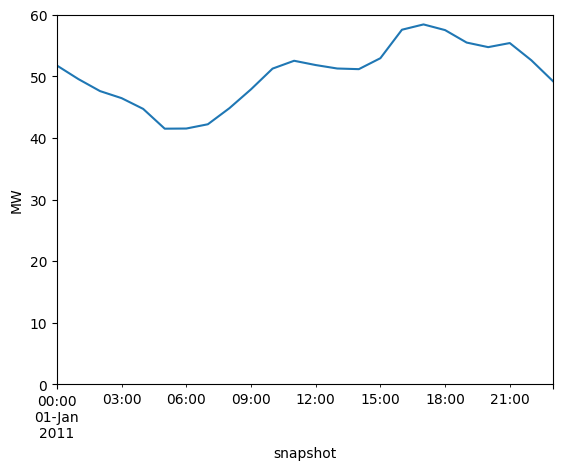

In [ ]:
n_de.loads_t.p_set.sum(axis=1).div(1e3).plot(ylim=[0, 60], ylabel="MW")

... and the capacity factor time series:

<Axes: xlabel='snapshot', ylabel='p.u.'>

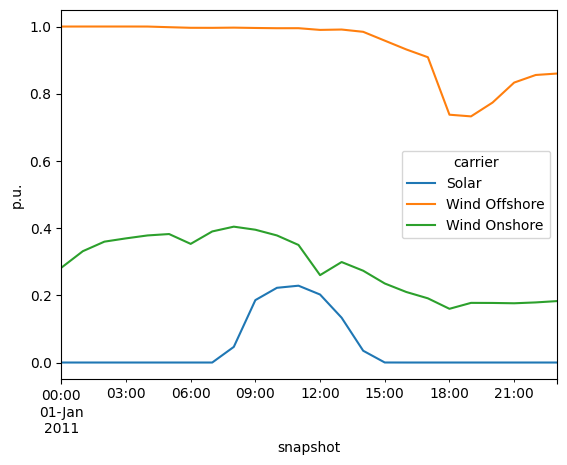

In [ ]:
n_de.generators_t.p_max_pu.groupby(n_de.generators.carrier, axis=1).mean().plot(ylabel="p.u.")

We can also inspect the total power plant capacities per technology...

Text(0.5, 0, 'GW')

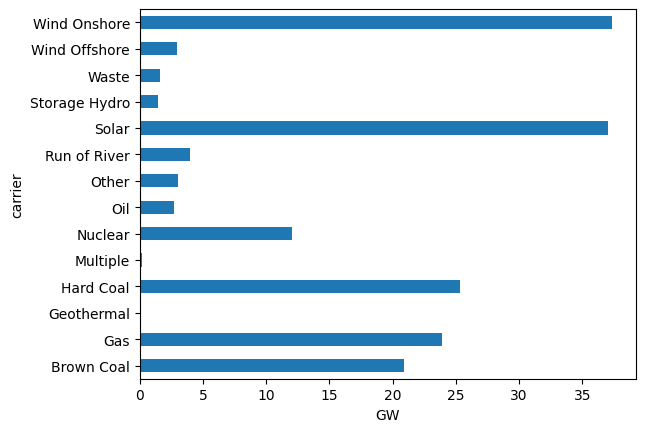

In [ ]:
n_de.generators.groupby("carrier").p_nom.sum().div(1e3).plot.barh()
plt.xlabel("GW")

... and plot the regional distribution of loads...

In [ ]:
load = n_de.loads_t.p_set.sum(axis=0).groupby(n_de.loads.bus).sum()

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



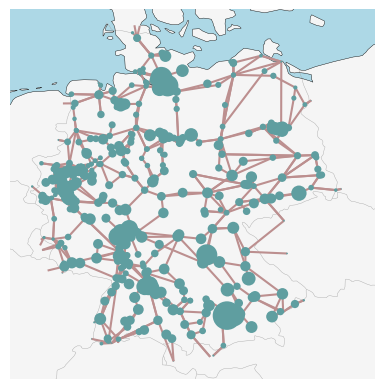

In [ ]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.EqualEarth())

n_de.plot(
    ax=ax,
    bus_sizes=load / 2e5,
    color_geomap=True,
);

... and power plant capacities:

In [ ]:
capacities = n_de.generators.groupby(["bus", "carrier"]).p_nom.sum()

For plotting we need to assign some colors to the technologies.

In [ ]:
import random

carriers = n_de.generators.carrier.unique()
colors = ["#%06x" % random.randint(0, 0xFFFFFF) for _ in carriers]
n_de.madd("Carrier", carriers, color=colors)

Index(['Gas', 'Hard Coal', 'Run of River', 'Waste', 'Brown Coal', 'Oil',
       'Storage Hydro', 'Other', 'Multiple', 'Nuclear', 'Geothermal',
       'Wind Offshore', 'Wind Onshore', 'Solar'],
      dtype='object')

Because we want to see which color represents which technology, we cann add a legend using the  `add_legend_patches` function of PyPSA.

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



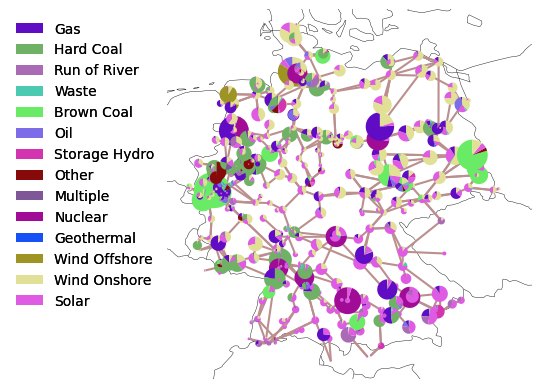

In [ ]:
from pypsa.plot import add_legend_patches

fig = plt.figure()
ax = plt.axes(projection=ccrs.EqualEarth())

n_de.plot(
    ax=ax,
    bus_sizes=capacities / 2e4,
)

add_legend_patches(
    ax, colors, carriers, legend_kw=dict(frameon=False, bbox_to_anchor=(0, 1))
)

This dataset also includes a few hydro storage units:

In [ ]:
n_de.storage_units.head(3)

,bus,p_nom,carrier,marginal_cost,max_hours,efficiency_store,efficiency_dispatch,control,type,p_nom_extendable,...,build_year,lifetime,state_of_charge_initial,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
100_220kV Pumped Hydro,100_220kV,144.5,Pumped Hydro,3.0,6.0,0.95,0.95,PQ,,False,...,0,inf,0.0,False,NaN,False,True,0.0,0.0,0.0
114 Pumped Hydro,114,138.0,Pumped Hydro,3.0,6.0,0.95,0.95,PQ,,False,...,0,inf,0.0,False,NaN,False,True,0.0,0.0,0.0
121 Pumped Hydro,121,238.0,Pumped Hydro,3.0,6.0,0.95,0.95,PQ,,False,...,0,inf,0.0,False,NaN,False,True,0.0,0.0,0.0


So let's solve the electricity market simulation for January 1, 2011. It'll take a short moment.

In [ ]:
n_de.optimize(solver_name="highs")

Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='Transformer')
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120

('ok', 'optimal')

Now, we can also plot model outputs, like the calculated power flows on the network map.

In [ ]:
line_loading = n_de.lines_t.p0.iloc[0].abs() / n_de.lines.s_nom / n_de.lines.s_max_pu * 100  # %

In [ ]:
norm = plt.Normalize(vmin=0, vmax=100)

<ipython-input-126-9dacfc58a02b>:14: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



/usr/local/lib/python3.10/dist-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



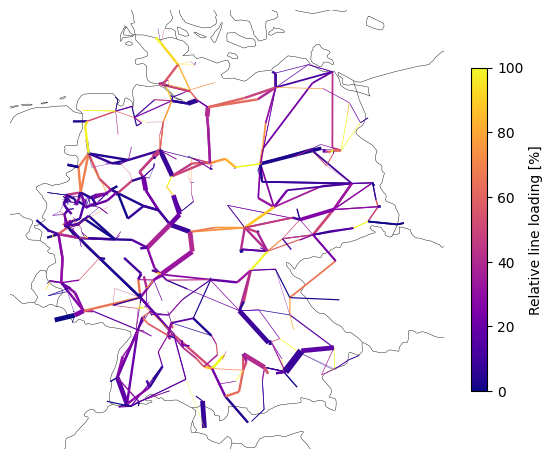

In [ ]:
import cartopy.crs as ccrs
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection=ccrs.EqualEarth())

n_de.plot(
    ax=ax,
    bus_sizes=0,
    line_colors=line_loading,
    line_norm=norm,
    line_cmap="plasma",
    line_widths=n_de.lines.s_nom / 1000,
)

plt.colorbar(
    plt.cm.ScalarMappable(cmap="plasma", norm=norm),
    label="Relative line loading [%]",
    shrink=0.6,
)

Or plot the hourly dispatch grouped by carrier:

In [ ]:
p_by_carrier = n_de.generators_t.p.groupby(n_de.generators.carrier, axis=1).sum().div(1e3)

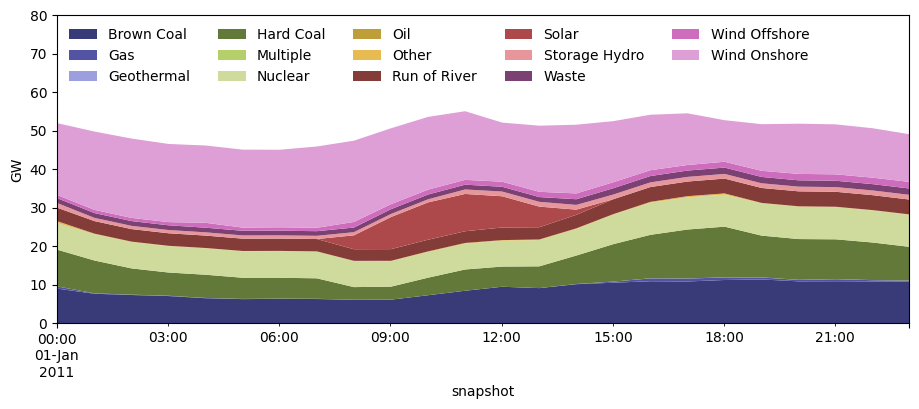

In [ ]:
fig, ax = plt.subplots(figsize=(11, 4))

p_by_carrier.plot(
    kind="area",
    ax=ax,
    linewidth=0,
    cmap="tab20b",
)

ax.legend(ncol=5, loc="upper left", frameon=False)

ax.set_ylabel("GW")

ax.set_ylim(0, 80);

Or plot the aggregate dispatch of the pumped hydro storage units and the state of charge throughout the day:

Text(0, 0.5, 'MWh or MW')

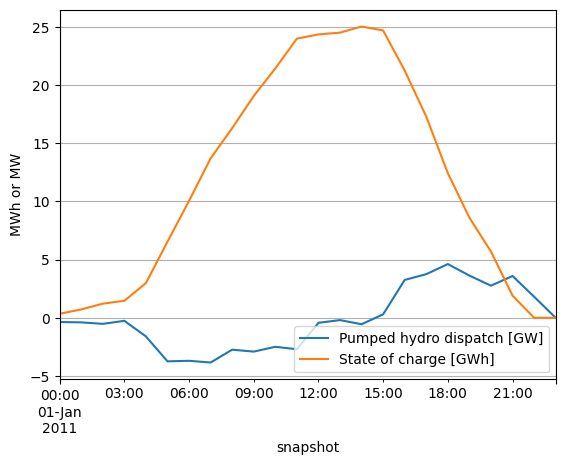

In [ ]:
fig, ax = plt.subplots()

p_storage = n_de.storage_units_t.p.sum(axis=1).div(1e3)
state_of_charge = n_de.storage_units_t.state_of_charge.sum(axis=1).div(1e3)

p_storage.plot(label="Pumped hydro dispatch [GW]", ax=ax)
state_of_charge.plot(label="State of charge [GWh]", ax=ax)

ax.grid()
ax.legend()
ax.set_ylabel("MWh or MW")

<Axes: xlabel='snapshot'>

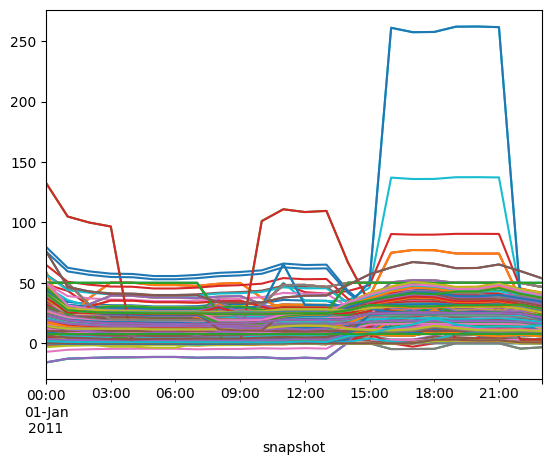

In [ ]:
n_de.buses_t.marginal_price.plot(legend=False)

Or plot the locational marginal prices (LMPs):

<ipython-input-130-ec8dd09bc9de>:13: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



/usr/local/lib/python3.10/dist-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



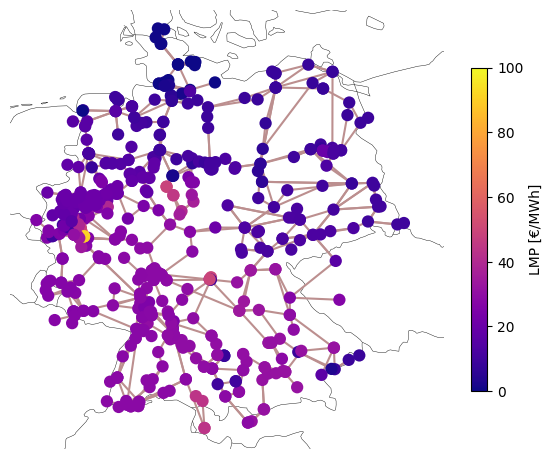

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection=ccrs.EqualEarth())

norm = plt.Normalize(vmin=0, vmax=100)  # €/MWh

n_de.plot(
    ax=ax,
    bus_colors=n_de.buses_t.marginal_price.mean(),
    bus_cmap="plasma",
    bus_norm=norm,
)

plt.colorbar(
    plt.cm.ScalarMappable(cmap="plasma", norm=norm), label="LMP [€/MWh]", shrink=0.6
)

In [ ]:
n_de.statistics()

Capacity Factor  Capital Expenditure   Curtailment  \
            carrier                                                             
Generator   Brown Coal            0.429382                  0.0      0.000000   
            Gas                   0.009640                  0.0      0.000000   
            Geothermal            0.242902                  0.0      0.000000   
            Hard Coal             0.305169                  0.0      0.000000   
            Multiple              0.000000                  0.0      0.000000   
            Nuclear               0.609652                  0.0      0.000000   
            Oil                   0.000000                  0.0      0.000000   
            Other                 0.050386                  0.0      0.000000   
            Run of River          0.864516                  0.0      0.000000   
            Solar                 0.051916                  0.0   1237.701692   
            Storage Hydro         0.729493                  0.0      0.000000   
            Waste                 0.847715                  0.0      0.000000   
            Wind Offshore         0.434619                  0.0  38457.505354   
            Wind Onshore          0.454434                  0.0  66195.956482   
Line        AC                    0.174661                  0.0           NaN   
Load        -                          NaN                  NaN           NaN   
StorageUnit Pumped Hydro          0.242101                  0.0      0.000000   
Transformer -                     0.120329                  0.0           NaN   

                               Dispatch  Installed Capacity  Market Value  \
            carrier                                                         
Generator   Brown Coal     2.151670e+05        20879.500000     13.773803   
            Gas            5.532691e+03        23913.130000     54.680848   
            Geothermal     1.848000e+02           31.700000     31.138284   
            Hard Coal      1.853909e+05        25312.600000     28.449849   
            Multiple       0.000000e+00          152.700000           NaN   
            Nuclear        1.765747e+05        12068.000000     12.220105   
            Oil            0.000000e+00         2710.200000           NaN   
            Other          3.661430e+03         3027.800000     42.526614   
            Run of River   8.297488e+04         3999.100000     24.328346   
            Solar          4.615334e+04        37041.524779     14.306729   
            Storage Hydro  2.529882e+04         1445.000000     15.014788   
            Waste          3.348611e+04         1645.900000     25.088735   
            Wind Offshore  3.101614e+04         2973.500000      5.075141   
            Wind Onshore   4.072443e+05        37339.895329      8.516334   
Line        AC             5.614437e+04       964399.770553    162.373628   
Load        -             -1.209952e+06                 NaN    -23.364407   
StorageUnit Pumped Hydro  -2.733419e+03         9179.500000    -66.754886   
Transformer -             -6.605396e+04       192000.000000     -8.881158   

                           Operational Expenditure  Optimal Capacity  \
            carrier                                                    
Generator   Brown Coal                2.151670e+06      20879.500000   
            Gas                       2.766346e+05      23913.130000   
            Geothermal                4.804800e+03         31.700000   
            Hard Coal                 4.634773e+06      25312.600000   
            Multiple                  0.000000e+00        152.700000   
            Nuclear                   1.412598e+06      12068.000000   
            Oil                       0.000000e+00       2710.200000   
            Other                     1.171657e+05       3027.800000   
            Run of River              2.489246e+05       3999.100000   
            Solar                     0.000000e+00      37041.524779   
 

Example Revenue Calculation for a given solar generator:

In [ ]:
n_de.generators_t.p['404_220kV Solar'] * n_de.buses_t.marginal_price['404_220kV']

snapshot
2011-01-01 00:00:00     -0.000000
2011-01-01 01:00:00     -0.000000
2011-01-01 02:00:00     -0.000000
2011-01-01 03:00:00     -0.000000
2011-01-01 04:00:00     -0.000000
2011-01-01 05:00:00     -0.000000
2011-01-01 06:00:00     -0.000000
2011-01-01 07:00:00     -0.000000
2011-01-01 08:00:00     59.163788
2011-01-01 09:00:00    142.358595
2011-01-01 10:00:00    168.317955
2011-01-01 11:00:00    180.814206
2011-01-01 12:00:00    160.156396
2011-01-01 13:00:00     35.953157
2011-01-01 14:00:00     16.574143
2011-01-01 15:00:00      2.444930
2011-01-01 16:00:00     -0.000000
2011-01-01 17:00:00     -0.000000
2011-01-01 18:00:00     -0.000000
2011-01-01 19:00:00     -0.000000
2011-01-01 20:00:00     -0.000000
2011-01-01 21:00:00     -0.000000
2011-01-01 22:00:00     -0.000000
2011-01-01 23:00:00     -0.000000
dtype: float64